Theodoros Kassa Aragie

251163893

ECE 9309

Prof. Soodeh Nikan

February 17, 2025

# Implementing Agglomerative Clustering for a Recommender System

Dataset 1: https://www.kaggle.com/datasets/pushkaranp/ieee-research-papers-dataset?resource=download

In [1]:
# Misc Imports
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# SciKit-Learn Imports
from sklearn.decomposition import PCA 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler 
import scipy.cluster.hierarchy as shc 
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

## Load Splitted Data, Normalize, Apply PCA

In [2]:
# Load in the preprocessed dataset splits
trnDF:pd.DataFrame = pd.read_parquet("./parquets/train.parquet.gzip")
tstDF:pd.DataFrame = pd.read_parquet("./parquets/test.parquet.gzip")
valDF:pd.DataFrame = pd.read_parquet("./parquets/val.parquet.gzip")
cleanedDF:pd.DataFrame = pd.read_parquet("./parquets/cleaned.parquet.gzip")

# Normalize the data
scaler = StandardScaler()
trnNorm:pd.DataFrame = pd.DataFrame(
    scaler.fit_transform(trnDF), columns=trnDF.columns
)
tstNorm:pd.DataFrame = pd.DataFrame(
    scaler.transform(tstDF), columns=tstDF.columns
)
valNorm:pd.DataFrame = pd.DataFrame(
    scaler.transform(valDF), columns=valDF.columns
)

# Apply PCA to reduce dimensionality to 2 features
pca:PCA = PCA(n_components=2).fit(trnNorm)
trnComp:pd.DataFrame = pd.DataFrame(
    pca.transform(trnNorm), columns=["P1", "P2"]
)
tstComp:pd.DataFrame = pd.DataFrame(
    pca.transform(tstNorm), columns=["P1", "P2"]
)
valComp:pd.DataFrame = pd.DataFrame(
    pca.transform(valNorm), columns=["P1", "P2"]
)

## Visualize Data and Determine the Best n_clusters for Agglomerative Clustering

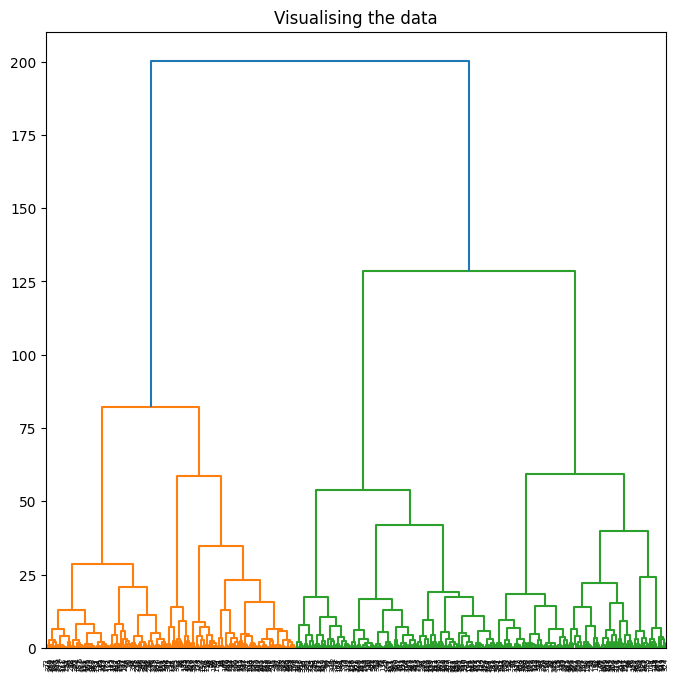

In [3]:
# Dendrogram
plt.figure(figsize =(8, 8)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(trnComp, method ='ward')))

[2, 3, 4, 5, 6]


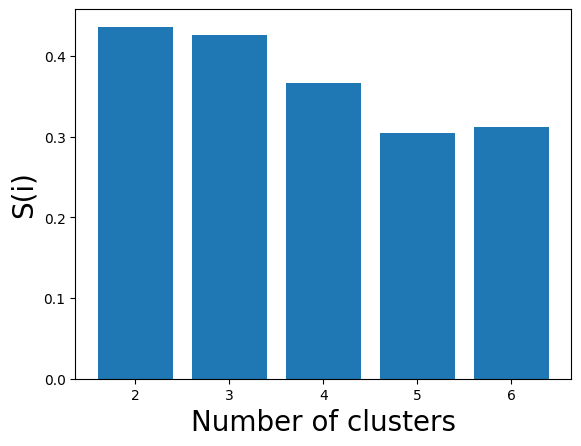

In [4]:
# Use silhouette scores to assess the best AC
# (AgglomerativeClustering) n_clusters value
kVals:list[int] = [i for i in range(2, 7)]
print(kVals)

silhScores:list = [
    silhouette_score(
        trnComp,
        AgglomerativeClustering(n_clusters=i).fit_predict(trnComp)
    ) for i in kVals
]

# Plotting a bar graph to compare the results 
plt.bar(kVals, silhScores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show()

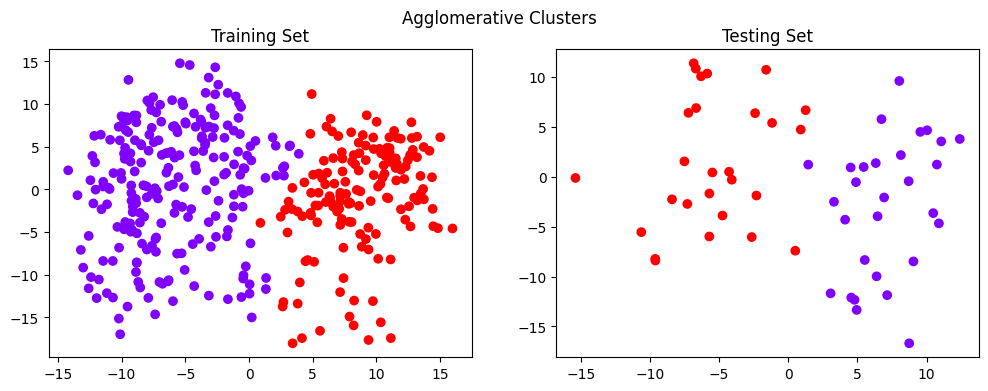

In [5]:
# Calculate labels using optimal AC clusters
bestAC:AgglomerativeClustering = AgglomerativeClustering(n_clusters=2)
trnLabels = bestAC.fit_predict(trnComp)
trnDF["cluster"] = trnLabels
tstLabels = bestAC.fit_predict(tstComp)
tstDF["cluster"] = tstLabels

# Plotting optimial AC clusters
plt.figure(figsize=(12, 4))
plt.suptitle("Agglomerative Clusters")
plt.subplot(1, 2, 1)
plt.scatter(
    trnComp['P1'], trnComp['P2'], 
    c = trnLabels,
    cmap ='rainbow'
)
plt.title("Training Set")
plt.subplot(1, 2, 2)
plt.scatter(
    tstComp['P1'], tstComp['P2'], 
    c = tstLabels,
    cmap ='rainbow'
)
plt.title("Testing Set")
plt.show()

## Make Recomendations, Cosine Similarity, Save Model

In [6]:
# Function to recommend top n papers (default to top_n=10)
def recommendPapers(testPaperIndex:int, top_n:int=10):
    testPaperClusters:pd.DataFrame = tstDF.iloc[
        testPaperIndex
    ]["cluster"]
    # Get all training papers in the same cluster
    sameClusterPapers:pd.DataFrame = trnDF[
        trnDF["cluster"] == testPaperClusters
    ]
    # Ensure index alignment before selecting PCA-reduced embeddings
    sameClusterIndices:pd.Index = sameClusterPapers.index.intersection(
        trnComp.index
    )
    # Get PCA-reduced vectors (Ensure both use PCA-reduced data)
    testEmbeddings:npt.NDArray = tstComp.iloc[
        testPaperIndex
    ].values.reshape(1, -1)
    trainEmbeddings:npt.NDArray = trnComp.loc[
        sameClusterIndices
    ].values  # Exclude cluster column
    # Compute cosine similarity
    similarities:npt.NDArray = cosine_similarity(
        testEmbeddings, trainEmbeddings
    )[0]
    # Get indices of top-N most similar papers, highest similarity first
    topIndices:npt.NDArray = np.argsort(similarities)[-top_n:][::-1]  
    return sorted(sameClusterIndices[topIndices].to_list())

# Example usage
topRecommendations:list[int] = recommendPapers(0, top_n=10)
print(cleanedDF.iloc[topRecommendations])


     Unnamed: 0   Id                                              title  \
4             4    4            kNN-STUFF: kNN STreaming Unit for Fpgas   
27           27   27  Solid-Electrolyte-Gated Graphene-Covered Metal...   
101         101  101  Improving IoT Federation Resiliency With Distr...   
120         120  120  A Smart Cell Monitoring System Based on Power ...   
163         163  163   Electrodynamics of Axial-Flow Rotary Blood Pumps   
191         191  191  Trapdoor Privacy in Public Key Encryption With...   
193         193  193  A Hybrid Algorithm for Recognition of Power Qu...   
227         227  227  Analysis of Sensor-Based Real-Time Balancing o...   
373         373  373  Data-Driven Network Simulation for Performance...   
391         391  391  xCorrection to “Classification of Poetry Text ...   

                   link  year  \
4    /document/8911384/  2019   
27   /document/8918306/  2019   
101  /document/9627902/  2021   
120  /document/9627991/  2021   
163  /doc

In [7]:
# Compute pairwise cosine similarity between test and train papers
cosSimMatrix:npt.NDArray = cosine_similarity(tstComp, trnComp)

# Compute average similarity score per test sample
avgSimScore:npt.NDArray = cosSimMatrix.mean(axis=1)

# Overall similarity score
avgTestSim:npt.NDArray = avgSimScore.mean()
print(f"Average Cosine Similarity Score for Test Set: {avgTestSim}")

# Save the trained model
joblib.dump(bestAC, "./dump/acModel.pkl")

Average Cosine Similarity Score for Test Set: -0.0035171257406903847


['./dump/acModel.pkl']

In [8]:
# Reload the model
loadedModel:AgglomerativeClustering = joblib.load("./dump/acModel.pkl")
valLabels = loadedModel.fit_predict(valComp)
valDF["cluster"] = valLabels

In [9]:
# Function to recommend top n papers (default to top_n=10)
def selectPapers(valPaperIndex:int, top_n:int=10):
    valPaperClusters:pd.DataFrame = valDF.iloc[
        valPaperIndex
    ]["cluster"]
    # Get all training papers in the same cluster
    sameClusterPapers:pd.DataFrame = trnDF[
        trnDF["cluster"] == valPaperClusters
    ]
    # Ensure index alignment before selecting PCA-reduced embeddings
    sameClusterIndices:pd.Index = sameClusterPapers.index.intersection(
        trnComp.index
    )
    # Get PCA-reduced vectors (Ensure both use PCA-reduced data)
    valEmbeddings:npt.NDArray = valComp.iloc[
        valPaperIndex
    ].values.reshape(1, -1)
    trainEmbeddings:npt.NDArray = trnComp.loc[
        sameClusterIndices
    ].values  # Exclude cluster column
    # Compute cosine similarity
    similarities:npt.NDArray = cosine_similarity(
        valEmbeddings, trainEmbeddings
    )
    # Get indices of top-N most similar papers, highest similarity first
    topIndices:npt.NDArray = np.argsort(similarities[0])[-top_n:][::-1]  
    return similarities, sorted(sameClusterIndices[topIndices].to_list())

# Test on new papers
valSims, topSelections = selectPapers(0, top_n=10)
print(cleanedDF.iloc[topSelections])

# Compute average similarity score per test sample
avgValScore:npt.NDArray = valSims.mean(axis=1)

# Overall similarity score
avgValSim:npt.NDArray = avgValScore.mean()
print(f"\nAverage Cosine Similarity Score for Test Set: {avgValSim}")

     Unnamed: 0   Id                                              title  \
1             1    1  The Use of Tangible User Interfaces in K12 Edu...   
13           13   13  Multicriteria Classifier Ensemble Learning for...   
41           41   41  System Dynamics Modeling and Simulation of Ent...   
143         143  143  Actionable Knowledge Discovery for Increasing ...   
186         186  186  Hybrid Stochastic Ranking for Constrained Opti...   
214         214  214  Performance Analysis of Long Short-Term Memory...   
231         231  231  Ensemble Feature Ranking for Cost-Based Non-Ov...   
235         235  235  IEEE Access Special Section Editorial: Recent ...   
280         280  280  A New Algorithm for Displaying Images With Hig...   
323         323  323  Demand-Side Power Paradigm-Oriented Analysis o...   

                   link  year  \
1    /document/9721879/  2022   
13   /document/9706443/  2022   
41   /document/9620037/  2021   
143  /document/8933045/  2019   
186  /doc

## TF-IDF and Feature Importance Plot

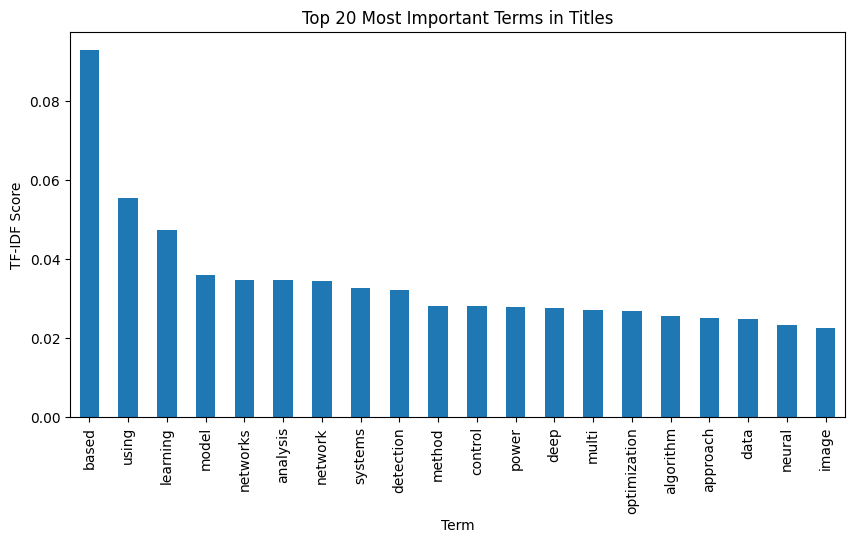

In [10]:
# Convert titles into TF-IDF representation
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = vectorizer.fit_transform(cleanedDF["title"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out()
)

# Plot top 20 TF-IDF terms
tfidf_df.mean().nlargest(20).plot(kind='bar', figsize=(10, 5))
plt.title("Top 20 Most Important Terms in Titles")
plt.xlabel("Term")
plt.ylabel("TF-IDF Score")
plt.show()